In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU here.
epoch = 200
batch_size = 128
eta_d = 0.001 
eta_p = 0.01
eta = 0.007
tem = 1e-4
rho = 0.5
bound = 8 / 255
L = 10

Some functions

In [3]:
def proj(x, sigma):
    return torch.clamp(x, min=-sigma, max=sigma)


def KL_div(output, labels):
    out_prob = F.log_softmax(output, dim=1)
    target = F.one_hot(labels, output.size(1)).float().to(output.device)
    return F.kl_div(out_prob, target, reduction='batchmean')


def generate_attack(img, labels, L, eta, bound, tem, net):
    net.eval()
    delta = torch.zeros_like(img, device=img.device, requires_grad=True)
    Laplace_dist = torch.distributions.Laplace(
    torch.tensor(0., device=img.device),
    torch.tensor(1., device=img.device)
    )
    
    for l in range(L):
        output = net(img+delta)
        l_pert = torch.log(KL_div(output, labels))
        
        if delta.grad is not None:
            delta.grad.zero_()
        l_pert.backward()
        noise = Laplace_dist.sample(img.shape)
        
        delta.data += eta * delta.grad.detach() + tem * noise
        delta.data = proj(delta, bound)
        delta.data = torch.clamp(img + delta.data, 0, 1) - img
        
    return delta.detach()

Evaluate functions

In [4]:
def test(net, testloader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


def adv_acc(net, testloader, device, bound=8/255, step_size=2/255, L=10):
    net.eval()
    correct = 0
    total = 0

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        delta = torch.zeros_like(inputs, requires_grad=True)
        delta.requires_grad = True

        for l in range(L):
            outputs = net(inputs + delta)
            loss = F.cross_entropy(outputs, labels)
            
            if delta.grad is not None:
                delta.grad.zero_()
            loss.backward()
            
            grad = delta.grad.detach()
            delta.data = delta + step_size * torch.sign(grad)
            delta.data = torch.clamp(delta, -bound, bound)
            delta.data = torch.clamp(inputs + delta.data, 0, 1) - inputs
            
        adv_inputs = inputs + delta.detach()
        outputs = net(adv_inputs)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return acc

Train function

In [5]:
def train(device,  net, trainloader, testloader, epoch, eta_p, eta_d, eta, rho, bound, tem, L):
    v = torch.tensor(0., device=device)
    CE = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.SGD(net.parameters(), lr=eta_p, momentum=0.9, weight_decay=3.5e-3)
    milestones=[150, 175, 190]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    
    clean_acc = []
    pgd20_acc = []
    FGSM_acc = []
    Loss_nom = []
    Loss_ro = []
    Dual_var = []
    for e in tqdm(range(epoch), desc="Training Epochs"):
        net.train()
        v_update = 0.
        total_num = 0
        L_ro = 0.
        L_nom = 0.
        rounds = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            batch = inputs.shape[0]
            total_num += batch
            rounds += 1
            
            delta = generate_attack(inputs, labels, L, eta, bound, tem, net)
            inputs_adv = torch.clamp(inputs + delta, 0, 1)
            net.train()
            
            optimizer.zero_grad()
            output = net(inputs)
            output_adv = net(inputs_adv.detach())
            l_ro = KL_div(output_adv, labels)
            l_nom = CE(output, labels)
            loss = l_ro + v * l_nom / batch
            loss.backward()
            optimizer.step()

            v_update += l_nom.detach()
            L_ro += l_ro
            L_nom += l_nom.detach() / batch
            
        scheduler.step()
        v += eta_d * (v_update / total_num - rho)
        v = F.relu(v)
        
        clean_acc.append(test(net, testloader, device))
        pgd20_acc.append(adv_acc(net, testloader, device, L=20))
        FGSM_acc.append(adv_acc(net, testloader, device, L=1))
        Loss_ro.append((L_ro / rounds).item())
        Loss_nom.append((L_nom / rounds).item())
        Dual_var.append(v.item())
            
    return net, [clean_acc, pgd20_acc, FGSM_acc, Loss_ro, Loss_nom, Dual_var]

DataLoader 

In [6]:
train_transforms = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])
test_transforms = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Net

In [7]:
net = torchvision.models.resnet18(num_classes=10)
net = net.to(device)

Training and reproduce the table

In [8]:
net, lines = train(device,  net, trainloader, testloader, epoch, eta_p, eta_d, eta, rho, bound, tem, L)
clean_acc = test(net, testloader, device)
FGSM_acc = adv_acc(net, testloader, device, L=1)
pgd_acc = adv_acc(net, testloader, device, L=20)
print("Final Evaluation Results:")
print(f"Clean Accuracy: {clean_acc:.4f}")
print(f"FGSM Accuracy: {FGSM_acc:.4f}")
print(f"PGD-20 Accuracy: {pgd_acc:.4f}")

Training Epochs: 100%|██████████| 200/200 [7:39:16<00:00, 137.78s/it]  


Final Evaluation Results:
Clean Accuracy: 0.8810
FGSM Accuracy: 0.5497
PGD-20 Accuracy: 0.0055


Plot

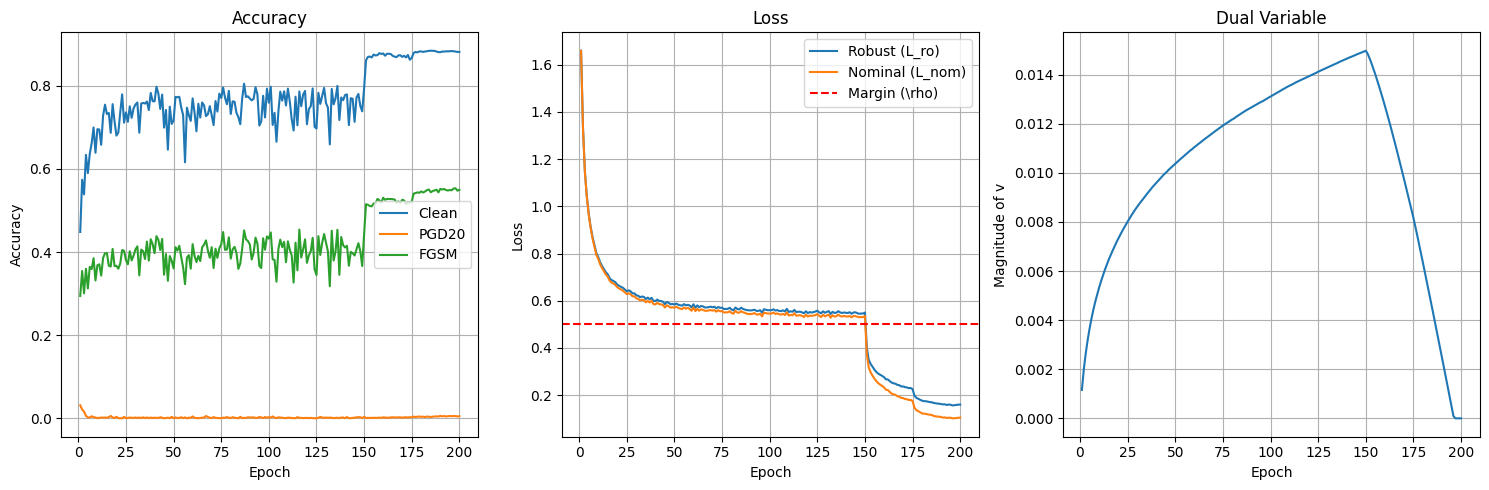

In [9]:
clean_acc, pgd20_acc, FGSM_acc, Loss_ro, Loss_nom, Dual_var = lines
epochs = range(1, len(clean_acc) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, clean_acc, label='Clean')
plt.plot(epochs, pgd20_acc, label='PGD20')
plt.plot(epochs, FGSM_acc, label='FGSM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, Loss_ro, label='Robust (L_ro)')
plt.plot(epochs, Loss_nom, label='Nominal (L_nom)')
plt.axhline(y=rho, color='r', linestyle='--', label='Margin (\\rho)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, Dual_var)
plt.xlabel('Epoch')
plt.ylabel('Magnitude of v')
plt.title('Dual Variable')
plt.grid(True)

plt.tight_layout()
plt.show()